# Market-implied stock price PDFs

Option prices embed information about the markets expectation of future performance of the underlying asset.
The set of European option prices across strikes for a given maturity $T$ implies a risk-neutral probability density function (details below) of the price $S_T$ of the underlying asset at the maturity.

This density reflects the distribution consistent with current option prices under the pricing measure that discounts payoffs at the risk-free rate.
It also reflects both how the market expects the underlying to move (although it is important to note that the pdf we obtain is NOT simply the market's prediction of where the stock is likely to move), as well as how the market prices risk across the various outcomes.

This project uses several years of daily SPX option chain data to extract the market-implied risk-neutral pdfs for options with 1 day maturities, 7 day maturities, and 28 day maturities.
Using the Breeden-Litzenberger relation, which says that the implied pdf is given by the second partial derivative of price at maturity with respect to strike:
$$ f_Q(K) = e^{rT} \frac{\partial^2 C(K, T)}{\partial K^2},$$
we numerically recover the pdf.
Since strikes come in discrete increments, techniques to interpolate in a suitable way are discussed.

We then discuss and compare ways of recovering the real-world probability distribution from the risk-neutral one.

There are two main goals of this project, and two secondary goals.
The main goals are
1. Compare the risk-neutral pdf to the realized price distribution.
2. Explore ways of estimating the real-world density function from the risk-neutral density.

The secondary goals are
* When it seems fruitful and interesting, I try to compare different numerical methods that arise during the process of accomplishing these goals.
* Give exposition of the theory and background needed to understand this topic so that a wider audience may find it useful and engaging.


## The data

The data I use was obtained from OptionsDX.
I have EOD options chain data for SPX for years 2020 through 2023.
I filtered for options with 1 day maturities, 7 day maturities, and 28 day maturities, so that I can compare all the methods across a range of expiration lengths.

To illustrate the idea, we'll just look at a single implied pdf from one collection of quotes.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from black_scholes import *     # utility functions related to the Black-Scholes formula

from scipy.interpolate import UnivariateSpline # for cubic interpolation with smoothing
from scipy.interpolate import make_splrep

In [2]:
spx_2020 = pd.read_csv("data/spx_options_2020.csv")

display(spx_2020)

,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix
0,3002.74,1583355600,1583269200,2020-03-03 16:00,1800.0,4.697070,1200.81,1210.10,1210.6,2.000980,0.00,0.05,0.10,1.0,86400
1,3002.74,1583355600,1583269200,2020-03-03 16:00,1900.0,,1097.10,1107.30,1130.7,1.798530,0.00,0.05,0.05,1.0,86400
2,3002.74,1583355600,1583269200,2020-03-03 16:00,1950.0,3.831740,1050.80,1060.11,0.0,1.702120,0.00,0.05,0.00,1.0,86400
3,3002.74,1583355600,1583269200,2020-03-03 16:00,2000.0,,995.10,1005.40,1102.6,1.606860,0.00,0.05,0.05,1.0,86400
4,3002.74,1583355600,1583269200,2020-03-03 16:00,2050.0,,945.60,955.79,0.0,1.515240,0.00,0.05,0.05,1.0,86400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82083,3624.23,1609189200,1606770000,2020-11-30 16:00,5000.0,0.344570,0.00,0.10,0.0,0.727370,1379.59,1389.40,0.00,28.0,2419200
82084,3624.23,1609189200,1606770000,2020-11-30 16:00,5100.0,0.375080,0.00,0.15,0.0,0.735480,1465.20,1490.51,0.00,28.0,2419200
82085,3624.23,1609189200,1606770000,2020-11-30 16:00,5200.0,0.365110,0.00,0.04,0.0,0.822860,1579.50,1589.30,0.00,28.0,2419200
82086,3624.23,1609189200,1606770000,2020-11-30 16:00,5300.0,0.383380,0.00,0.05,0.0,0.870090,1679.51,1689.30,0.00,28.0,2419200


In [3]:
data_years = ["2020", "2021", "2022", "2023"]

spx_dfs = [
    pd.read_csv(f"data/spx_options_{year}.csv")
    for year in data_years
]

spx_df = pd.concat(spx_dfs, ignore_index=True).dropna()

# add a column for the time to expiry in years
spx_df['tte_years'] = spx_df['tte_unix']/(60*60*24*365)


numeric_cols = ['call_iv', 'call_last', 'put_last'] # TODO: and some more
for col in numeric_cols:
    spx_df[col] = pd.to_numeric(spx_df[col], errors="coerce")


spx_df['call_bid'] = pd.to_numeric(spx_df['call_bid'], errors='coerce')
spx_df['call_ask'] = pd.to_numeric(spx_df['call_ask'], errors='coerce')
spx_df['put_bid'] = pd.to_numeric(spx_df['put_bid'], errors='coerce')
spx_df['put_ask'] = pd.to_numeric(spx_df['put_ask'], errors='coerce')

for option_type in ['call', 'put']:
    spx_df[f'{option_type}_mid'] = (spx_df[f'{option_type}_ask'] + spx_df[f'{option_type}_bid'])/2

display(spx_df)

spx_1dte = spx_df[spx_df['tte_unix'] == 60*60*24]
spx_7dte = spx_df[spx_df['tte_unix'] == 60*60*24*7]
spx_28dte = spx_df[spx_df['tte_unix'] == 60*60*24*28]

# create a collection of dataframes, one for each day
spx_1dte_dfs = [
    spx_1dte[spx_1dte['quote_unix'] == utime]
    for utime in spx_1dte['quote_unix'].unique()
]

spx_7dte_dfs = [
    spx_7dte[spx_7dte['quote_unix'] == utime]
    for utime in spx_7dte['quote_unix'].unique()
]

spx_28dte_dfs = [
    spx_28dte[spx_28dte['quote_unix'] == utime]
    for utime in spx_28dte['quote_unix'].unique()
]

display(spx_1dte_dfs[0])


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,tte_years,call_mid,put_mid
0,3002.74,1583355600,1583269200,2020-03-03 16:00,1800.0,4.69707,1200.81,1210.10,1210.60,2.000980,0.0,0.05,0.10,1.0,86400,0.002740,1205.455,0.025
1,3002.74,1583355600,1583269200,2020-03-03 16:00,1900.0,NaN,1097.10,1107.30,1130.70,1.798530,0.0,0.05,0.05,1.0,86400,0.002740,1102.200,0.025
2,3002.74,1583355600,1583269200,2020-03-03 16:00,1950.0,3.83174,1050.80,1060.11,0.00,1.702120,0.0,0.05,0.00,1.0,86400,0.002740,1055.455,0.025
3,3002.74,1583355600,1583269200,2020-03-03 16:00,2000.0,NaN,995.10,1005.40,1102.60,1.606860,0.0,0.05,0.05,1.0,86400,0.002740,1000.250,0.025
4,3002.74,1583355600,1583269200,2020-03-03 16:00,2050.0,NaN,945.60,955.79,0.00,1.515240,0.0,0.05,0.05,1.0,86400,0.002740,950.695,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374062,4109.88,1682712000,1680292800,2023-03-31 16:00,5000.0,0.21516,0.00,0.10,0.05,,874.1,877.30,1008.61,28.0,2419200,0.076712,0.050,875.700
374063,4109.88,1682712000,1680292800,2023-03-31 16:00,5100.0,0.23487,0.00,0.10,0.05,,973.8,977.00,0.00,28.0,2419200,0.076712,0.050,975.400
374064,4109.88,1682712000,1680292800,2023-03-31 16:00,5200.0,0.25483,0.00,0.10,0.05,,1072.7,1075.90,0.00,28.0,2419200,0.076712,0.050,1074.300
374065,4109.88,1682712000,1680292800,2023-03-31 16:00,5300.0,0.26052,0.00,0.05,0.05,,1172.8,1176.30,0.00,28.0,2419200,0.076712,0.025,1174.550


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,tte_years,call_mid,put_mid
0,3002.74,1583355600,1583269200,2020-03-03 16:00,1800.0,4.69707,1200.81,1210.10,1210.60,2.000980,0.00,0.05,0.10,1.0,86400,0.00274,1205.455,0.025
1,3002.74,1583355600,1583269200,2020-03-03 16:00,1900.0,NaN,1097.10,1107.30,1130.70,1.798530,0.00,0.05,0.05,1.0,86400,0.00274,1102.200,0.025
2,3002.74,1583355600,1583269200,2020-03-03 16:00,1950.0,3.83174,1050.80,1060.11,0.00,1.702120,0.00,0.05,0.00,1.0,86400,0.00274,1055.455,0.025
3,3002.74,1583355600,1583269200,2020-03-03 16:00,2000.0,NaN,995.10,1005.40,1102.60,1.606860,0.00,0.05,0.05,1.0,86400,0.00274,1000.250,0.025
4,3002.74,1583355600,1583269200,2020-03-03 16:00,2050.0,NaN,945.60,955.79,0.00,1.515240,0.00,0.05,0.05,1.0,86400,0.00274,950.695,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,3002.74,1583355600,1583269200,2020-03-03 16:00,3700.0,0.90667,0.00,0.11,0.07,,689.59,699.90,0.00,1.0,86400,0.00274,0.055,694.745
222,3002.74,1583355600,1583269200,2020-03-03 16:00,3750.0,0.95840,0.00,0.10,0.07,,739.60,749.90,0.00,1.0,86400,0.00274,0.050,744.750
223,3002.74,1583355600,1583269200,2020-03-03 16:00,3800.0,1.00996,0.00,0.10,0.00,,789.60,799.90,0.00,1.0,86400,0.00274,0.050,794.750
224,3002.74,1583355600,1583269200,2020-03-03 16:00,3850.0,1.06078,0.00,0.10,0.00,,839.60,849.90,0.00,1.0,86400,0.00274,0.050,844.750


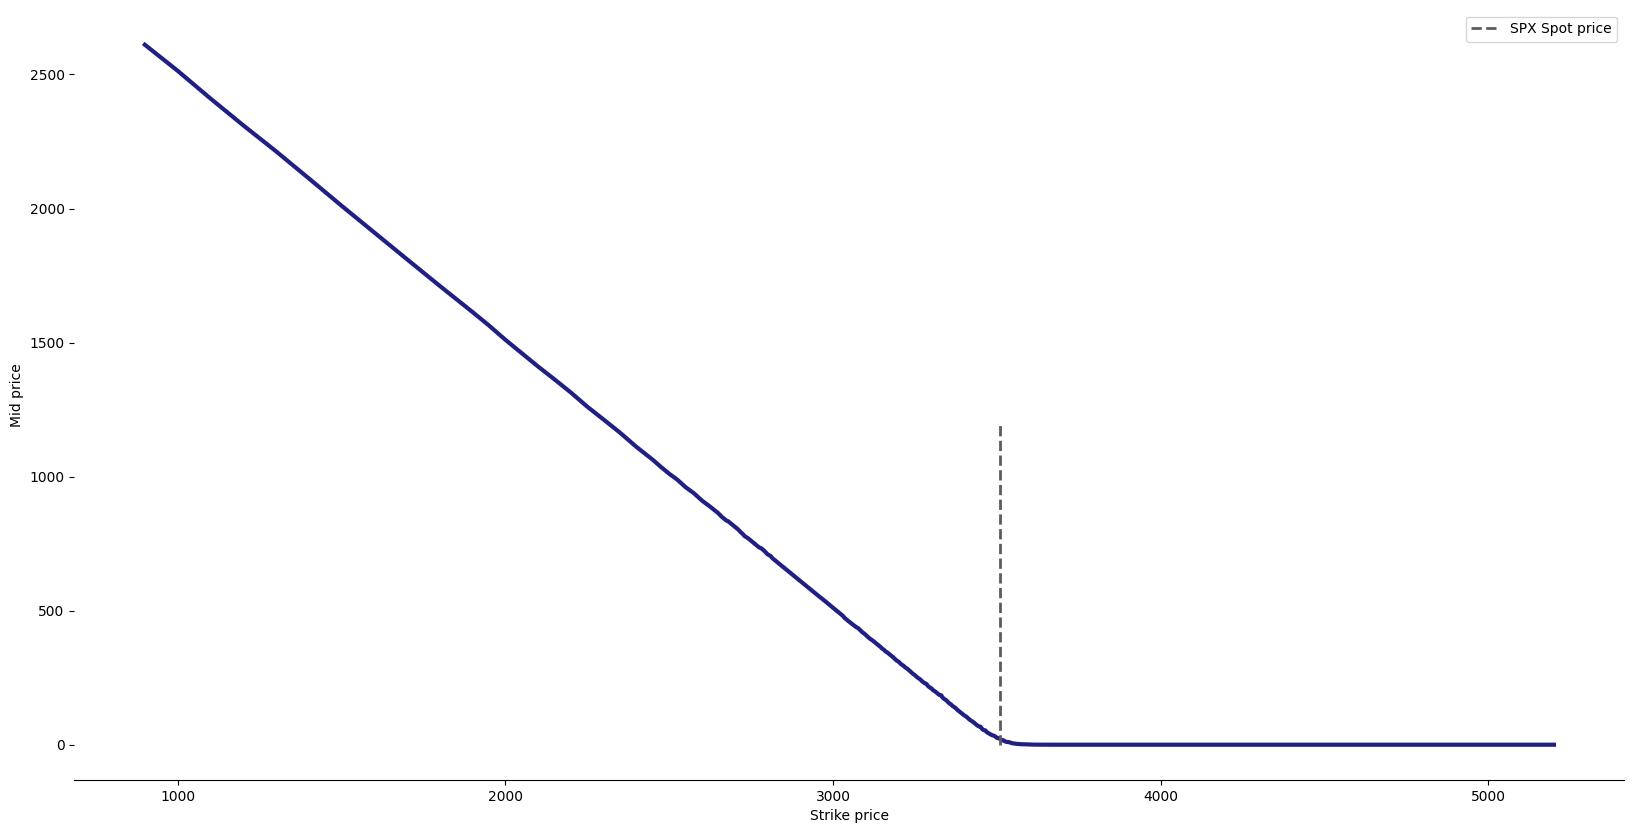

In [4]:
fig, ax = plt.subplots(figsize=(20,10))

# for df in spx_1dte_dfs:
    # ax.plot(df['strike'], df['call_mid'], alpha=.1)

df = spx_1dte_dfs[100].copy()
ax.plot(df['strike'], df['call_mid'], color="#1F1F84", linewidth=3)
ax.vlines(df['underlying_last'].mean(), ymin=0, ymax=1200, color="#5C5C5C", linestyle="--", linewidth=2, label="SPX Spot price")

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("Strike price")
ax.set_ylabel("Mid price");
ax.legend()


In order to apply the formula that we want, we need to interpolate this to a smooth function.
Interpolating on prices directly is dangerous as it can lead to spurious arbitrage opportunities.
It makes more sense to convert these prices to IV using Black-Scholes, interpolate on IV, and then convert back.
(Note that this data does come with an implied volatility included, but I'll calculate my own so that I know exactly where it comes from.)


(TODO: I still don't quite understand why this is better.)

,strike,implied_volatility,underlying_last
360051,2000.0,0.768830,4137.75
360052,2200.0,0.856376,4137.75
360053,2400.0,0.814945,4137.75
360054,2600.0,0.712066,4137.75
360055,2800.0,0.648406,4137.75
...,...,...,...
360162,4500.0,0.121663,4137.75
360163,4600.0,0.136500,4137.75
360164,4800.0,0.171078,4137.75
360165,5000.0,0.213627,4137.75


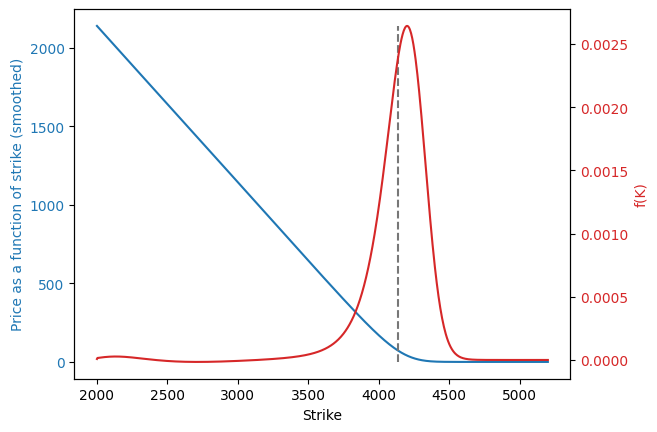

,strike,implied_volatility,underlying_last
349495,1800.0,1.024074,4136.58
349496,2000.0,0.994738,4136.58
349497,2200.0,0.951289,4136.58
349498,2400.0,0.858804,4136.58
349499,2600.0,0.771241,4136.58
...,...,...,...
349559,4600.0,0.136831,4136.58
349560,4800.0,0.171380,4136.58
349561,5000.0,0.213924,4136.58
349562,5200.0,0.241628,4136.58


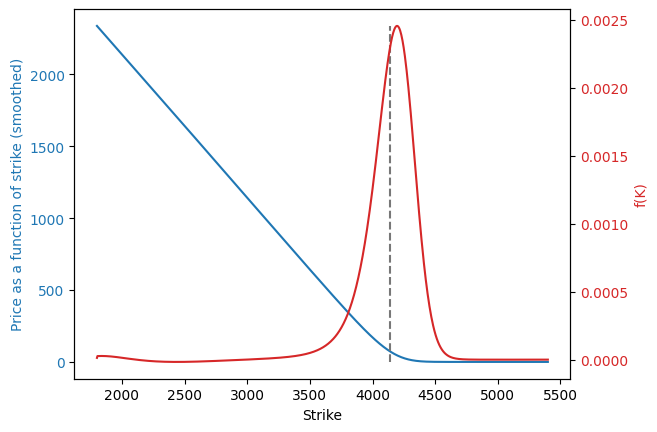

,strike,implied_volatility,underlying_last
317642,800.0,2.214242,4281.37
317643,1000.0,2.073368,4281.37
317644,1200.0,1.870684,4281.37
317645,1400.0,1.688048,4281.37
317646,1500.0,1.643153,4281.37
...,...,...,...
317972,5100.0,0.198264,4281.37
317973,5200.0,0.218311,4281.37
317974,5300.0,0.237821,4281.37
317975,5400.0,0.244293,4281.37


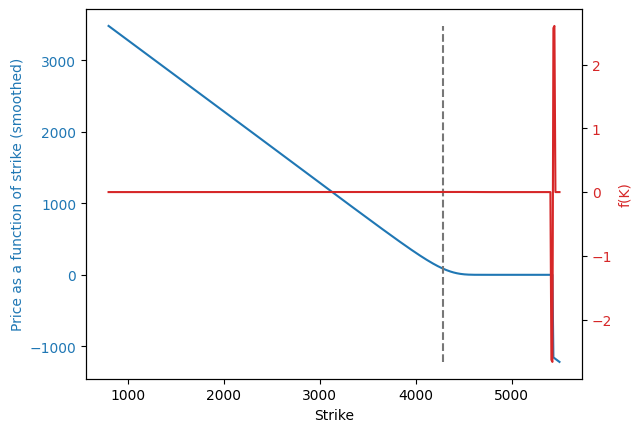

,strike,implied_volatility,underlying_last
202142,2200.0,0.628334,3954.1
202144,2600.0,0.621815,3954.1
202145,2800.0,0.611294,3954.1
202146,2900.0,0.564635,3954.1
202147,3000.0,0.475374,3954.1
...,...,...,...
202227,4300.0,0.198025,3954.1
202228,4400.0,0.199753,3954.1
202229,4600.0,0.216416,3954.1
202230,4800.0,0.236393,3954.1


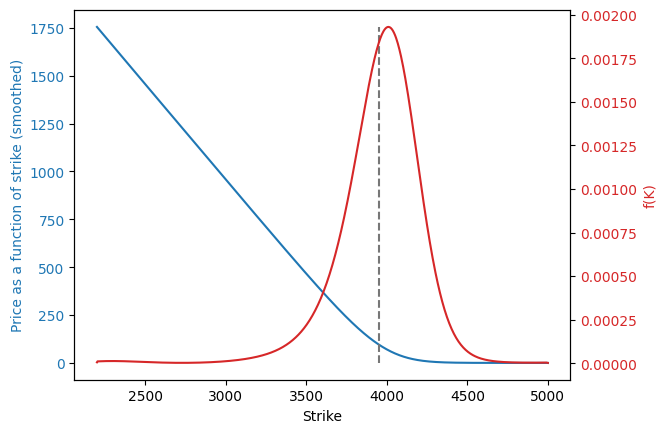

,strike,implied_volatility,underlying_last
262858,2000.0,0.760035,3899.98
262859,2200.0,0.761292,3899.98
262860,2400.0,0.700070,3899.98
262861,2600.0,0.626908,3899.98
262862,2800.0,0.442114,3899.98
262863,3000.0,0.420443,3899.98
262864,3100.0,0.395032,3899.98
262865,3150.0,0.382550,3899.98
262866,3200.0,0.368780,3899.98
262867,3250.0,0.357381,3899.98


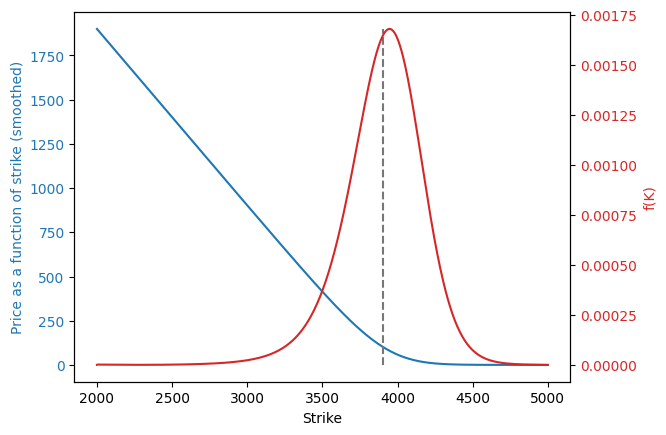

In [12]:
from black_scholes import *
from math import sqrt
import random
from scipy.interpolate import make_smoothing_spline, make_lsq_spline, CubicSpline

def fit_iv_spline(K, iv, F, smoothing_factor=None):


    k_vals = np.log(K / F)
    if smoothing_factor is None:
        n = len(k_vals)
        smoothing_factor = 0.005 * n

    spline_iv = make_splrep(k_vals, iv, k=3, s=smoothing_factor)
    return spline_iv, k_vals


def fit_iv(strikes, ivs, forward):
    """
    Fit a smooth implied volatility (IV) curve as a function of strike prices.

    This function takes a set of implied volatilities observed at discrete strike prices,
    converts them into log-moneyness space, fits a spline to the IV curve, and then 
    resamples the fitted curve on a fine grid for smoothness. The resampled log-moneyness 
    grid is then converted back to strike prices.

    Parameters
    ----------
    strikes : array-like
        Array of strike prices corresponding to the implied volatilities.
    ivs : array-like
        Array of implied volatilities (in decimals, not percentages) corresponding to `strikes`.
    forward : float
        The current forward price of the underlying asset.

    Returns
    -------
    K_grid : ndarray
        The resampled grid of strike prices.
    iv_smooth_lms : ndarray
        The smoothed implied volatilities corresponding to `K_grid`.
    spline_iv_strike : callable
        The fitted spline function mapping strike to implied volatility.

    Notes
    -----
    - The function assumes that the helper functions `fit_iv_spline` and `resample_curve` 
      are available in the environment.
    - Log-moneyness is defined as `log(K / forward)`.
    """
    spline_iv, log_moneyness_vals = fit_iv_spline(strikes, ivs, forward)
    lm_grid, iv_smooth_lms = resample_curve(spline_iv, log_moneyness_vals, 1000)
    K_grid = forward * np.exp(lm_grid)

    spline_iv_strike = lambda strike: spline_iv(np.log(strike/forward))

    return K_grid, iv_smooth_lms, spline_iv_strike


    # plt.plot(strikes, iv, label="strike vs iv")
    # plt.plot(K_grid, iv_smooth_lms, label="Smoothed cubic spline from log-moneyness vs iv")
    # plt.legend()
    # plt.show()
    

def resample_curve(c, x, n):
    """
    Resample the curve c(x) with n points.
    """

    x_grid = np.linspace(x.min(), x.max(), n)
    c_grid = c(x_grid)
    return x_grid, c_grid


def create_pdf(strikes, implied_volatilities, underlying_prices, tte_years, spot_price):
    """
    Construct a market-implied probability density function (PDF) for the underlying asset price at option expiration.

    This function uses the set of option-implied volatilities (or prices) across strike prices
    to derive the risk-neutral probability density function (PDF) of the underlying asset's
    terminal price. The resulting distribution reflects the market's collective expectation
    of possible future outcomes under the risk-neutral measure.

    Parameters
    ----------
    strikes : array-like
        Array of strike prices corresponding to the observed implied volatilities or option prices.
    implied_volatilities : array-like
        Array of implied volatilities for each strike, typically expressed as annualized decimals.
        These are used to infer option prices (if not provided) and construct the implied distribution.
    underlying_prices : array-like
        Array of option market prices corresponding to the given strikes and maturities.
        If provided, these can be used directly to estimate the risk-neutral density.
    tte_years : float or array-like
        Time to expiration (T) in years for the options used to infer the PDF.
    spot_price : float
        Current underlying (spot) price of the asset.

    Returns
    -------
    strikes_fine : ndarray
        Array of strikes over which bs_prices_fine is evaluated.
    bs_prices_fine : ndarray
        Array of smoothed option prices.
    f_2 : callable
        A function that takes a price (or array of prices) and returns the estimated probability density.

    Notes
    -----
    - The market-implied PDF is derived from the second derivative of the option price
      with respect to strike (the Breeden–Litzenberger formula):
        f(S_T) = exp(rT) * ∂²C(K, T)/∂K² |_(K=S_T)
    - This approach provides a risk-neutral, not a real-world, distribution.
    - Smoothing or interpolation of implied volatilities across strikes is performed
      before numerical differentiation to ensure stability.
    """


    #############################################################################################################################
    ## TODO: in this section we are not using a very clever method to fit a curve to the data; this can definitely be improved ##
    #############################################################################################################################


    # in this step we may be dropping quite a few rows
    # since often the IV cannot be calculated
    # smoothing_df = df[['strike', 'implied_volatility', 'underlying_last', 'tte_years']].dropna()
    smoothing_df = pd.DataFrame(data={"strike": strikes, "implied_volatility": implied_volatilities, "underlying_last": underlying_prices}).dropna() # tte_years, spot_price)
    # x = smoothing_df['strike']
    # y = smoothing_df['implied_volatility']

    display(smoothing_df)

    x = smoothing_df['strike']
    y = smoothing_df['implied_volatility']

    strikes_fine = np.linspace(x.min(), x.max(), 1000)


    ################################################
    # one method: fit a cubic spline to log-moneyness
    ################################################
    # order = np.argsort(x)
    # K = x[order]
    # iv = y[order]
    K = x
    iv = y
    r=0.05

    strikes_fine, iv_fine, spline_iv_strike = fit_iv(
        strikes=x,
        ivs=y,
        forward=spot_price * np.exp(r * tte_years)
    )



    # iv_smooth_lms = log_moneyness_spline(log_moneyness)
    # K_grid = S * np.exp(strikes_fine)

    # print(K_grid, iv_smooth_lms)
    # plt.plot(strikes_fine, iv_smooth_lms, label="log moneyness")
    # plt.legend()
    # plt.show()
    ################################################
    ################################################
    ## Another method: quintic spline just fit to strike vs iv
    ################################################
    # s = sqrt(2*len(x))
    # df_iv_smoothed = make_splrep(x, y, k=5, s=s)
    # # df_iv_smoothed_lsq = make_lsq_spline(x, y)
    # df_iv_smoothed_spline = make_smoothing_spline(x, y, lam=100)

    # iv_fine = df_iv_smoothed(strikes_fine)
    # iv_fine_cubic = df_iv_smoothed_spline(strikes_fine)
    # iv_fine_spline = df_iv_cubic_spline(strikes_fine)

    # plt.plot(strikes_fine, iv_fine, 'r', label="Smoothed quintic fit", alpha=0.5)
    # plt.scatter(x, y)
    # plt.legend()
    # plt.show()
    ################################################
    ################################################



    #############################################################################################################################
    #############################################################################################################################




    # now convert back to prices using Black-Scholes
    smoothing_df['smoothed_price_from_moneyness'] = smoothing_df.apply(
        lambda row: bs_call(
            S0 = spot_price,
            K = row['strike'],
            # sigma = spline_iv(np.log(row['strike'] / F)),
            sigma = spline_iv_strike(row['strike']),
            t=tte_years,
            r=0.05
        ),
        axis=1
    )

    # plt.plot(smoothing_df['strike'], smoothing_df['smoothed_price_from_moneyness'], alpha=.5)
    # plt.show()


    # now take the second derivative of (smoothed) price with respect to strike to generate a pdf
    # note that the smoothed_price row is a function of strike, so we need to resample in order to take a derivative

    # resample
    bs_prices_fine = np.zeros(len(strikes_fine))
    for i in range(len(bs_prices_fine)):
        bs_prices_fine[i] = bs_call(S0 = spot_price,
                        K=strikes_fine[i],
                    sigma=iv_fine[i],
                    t=tte_years,
                    r=0.0 # TODO: update
        )

    f = np.gradient(bs_prices_fine, strikes_fine)
    f_2 = np.gradient(f, strikes_fine)

    return strikes_fine, bs_prices_fine, CubicSpline(strikes_fine, f_2)



for _ in range(5):
    df = spx_28dte_dfs[random.randint(0, len(spx_1dte_dfs))].copy()

    spot_price = df['underlying_last'].mean()   # I am taking the mean just in case, but the underlying_last column should contain only one number
    tte_years = df['tte_years'].mean()          # same deal here

    df['implied_volatility'] = df.apply(
        lambda row: implied_volatility_call(
            market_price=row['call_mid'],
            S0 = row['underlying_last'],
            K=row['strike'],
            t=row['tte_years'],
            r=0.0
        ),
        axis=1
    )

    strikes_fine, bs_prices_fine, f_2 = create_pdf(
        strikes=df['strike'],
        implied_volatilities=df['implied_volatility'],
        underlying_prices=df["underlying_last"],
        tte_years=tte_years,
        spot_price=spot_price
    )


    fig, ax1 = plt.subplots()

    ax1.plot(strikes_fine, bs_prices_fine)
    ax1.set_xlabel('Strike')
    ax1.set_ylabel('Price as a function of strike (smoothed)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(strikes_fine, f_2(strikes_fine), color='tab:red', label='pdf')
    ax2.set_ylabel('f(K)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    ax1.vlines(x=spot_price, ymin=bs_prices_fine.min(), ymax=bs_prices_fine.max(), color="#777777", linestyles="--")
    plt.show()



Now we need to do a little numeric differentiation to apply the Breeden-Litzenberger formula, which says that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}$$


### The Breeden-Litzenberger Formula
Recall that the fair value of a call option with time $\tau$ until expiry is the present value of the expected payoff.
If $f$ denotes the PDF of the stock prices $S_T$ of some stock $S$ at time $T$, this is
$$
\begin{align*}
C(K, \tau) &= e^{-rt} \mathbb E(\max\{S_T - K, 0\}) \\
&= e^{-rt} \int_0^\infty \max\{S_T - K, 0\} f(S_T) \, d S_T \\
&= e^{-rt} \int_K^\infty (x - K) f(x) \, dx.
\end{align*}
$$
To derive the Breeden-Litzenberger formula, we just need to invert this to find $f$ as a function of $C$.
Taking the partial derivative with respect to $K$ gives
$$
\begin{align*}
\frac{\partial C}{\partial K} &= - e^{-rt} \int_{K}^\infty f(x) \, dx \\
&= e^{-rt} \left( \int_{-\infty}^K f(x) \, dx - 1 \right),
\end{align*}
$$
where in the second step we use the fact that $\int_{\R} f(x) \, dx = 1$.
But now we can find $f$ by taking one more derivative.
Doing this and rearranging, we see that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}.$$

In [ ]:
SIZE_DEFAULT = 16

plt.rcParams["xtick.labelsize"] = SIZE_DEFAULT


So we see what the market thinks the price of SPY is likely to be in one month.
We also need to do this analysis for the puts, and for the calls and puts with 2-month expiries.

## Comparing this to market data

The method that we'll use to evaluate the accuracy of the predictions is called the **continuous ranked probability score.**
It is defined by
$$ C(D, y) = \int_{\R} (F_D(x) - H(x-y))^2 \, dx, $$
where $F_D$ is the cumulative distribution function of the forecasted distribution $D$, $H$ is the Heaviside step function, and $y \in \R$ is the observation.

We can numerically approximate this using the fact that for distributions with finite first moment, the CRPS can be written as
$$C(D, y) = \mathbb E[|X - y|] - \frac 1 2 \mathbb E[|X - X'|],$$
where $X, X'$ are independent random variables sampled from $D$.



In [ ]:
def crps(D, y, n_samples=10_000):
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a given predictive
    distribution and observation using a Monte Carlo approximation.

    The CRPS measures the accuracy of probabilistic forecasts by comparing the
    cumulative distribution function (CDF) of the predictive distribution to the
    observed outcome. Lower scores indicate better probabilistic calibration and
    sharpness.

    Parameters
    ----------
    D : callable
        Predictive distribution for the quantity of interest. Must be a function
        that, when called as `D(n_samples)`, returns `n_samples` i.i.d. samples
        from the forecast distribution (as an array-like object).
    y : float
        The observed (realized) value of the variable being forecast.
    n_samples : int, optional
        Number of Monte Carlo samples to draw from D. Larger values yield a
        more accurate approximation at higher computational cost. Default is 10_000.

    Returns
    -------
    float
        The estimated CRPS value for the predictive distribution D with respect
        to the observation y.

    Notes
    -----
    The CRPS is defined as:
        CRPS(F, y) = E_F[|X - y|] - 0.5 * E_F[|X - X'|]
    where X and X' are independent random variables drawn from the predictive
    distribution F. Monte Carlo methods approximate these expectations using
    finite samples from D.
    """
    # Draw Monte Carlo samples from the predictive distribution
    samples = np.asarray(D(n_samples), dtype=float).ravel()
    if samples.size == 0:
        raise ValueError("D(n_samples) must return at least one sample.")

    x = samples

    # First term: E[|X - y|]
    term1 = np.mean(np.abs(x - y))

    # Second term: E[|X - X'|]
    # we can be efficient by using the fact that for sorted x_k,
    # \sum_{i,j} |x_i - x_j| = 2 * \sum_{k=1}^n (2k - n - 1) x_k
    # only one loop needed yay
    x_sorted = np.sort(x)
    n = x_sorted.size

    if n == 1:
        exx = 0.0
    else:
        indices = np.arange(1, n + 1, dtype=float)  # 1-based indices
        coeffs = 2 * indices - n - 1
        sum_abs = 2.0 * np.sum(coeffs * x_sorted)
        exx = sum_abs / (n ** 2)  # E[|X - X'|]

    return float(term1 - 0.5 * exx)

print(crps(f_2, 100))


TypeError: 'numpy.ndarray' object is not callable



We'll start by downloading the SPX data for the same range that we have option data.

In [ ]:
earliest_day = pd.to_datetime(spx_df['quote_time']).min()
latest_day = pd.to_datetime(spx_df['quote_time']).max()

data = yf.download("^SPX", start=earliest_day, end=latest_day)
display(data)

/tmp/ipykernel_2231081/837285114.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^SPX", start=earliest_day, end=latest_day)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
...,...,...,...,...,...
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000


# References and further reading

[Estimating the real-world density from the option-implied risk-neutral density, a paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2093397)

[A blog post about market-implied probabilities](https://blog.thinknewfound.com/2017/11/market-implied-probabilities-useful/)

[Wikipedia article on scoring rules](https://en.wikipedia.org/wiki/Scoring_rule).
These are rules that are used to assign a score to a predicted probability distribution and an observed value; exactly what we are doing to compare the risk-neutral distributions to real market movements.

In [ ]:
SIZE_DEFAULT = 16

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = SIZE_DEFAULT